## YOLO Algortihm with Custom Data Training

In [6]:
from ultralytics import YOLO
import cv2
import math

In [16]:
import torch

# Example list of Tensors
tensor_list = [torch.randn(3, 4), torch.randn(3, 4)]

if len(tensor_list) > 0:
    try:
        concatenated_tensor = torch.cat(tensor_list, dim=0)  # Concatenate along dimension 0
        # Proceed with further operations using the concatenated_tensor

    except RuntimeError as e:
        # Handle the specific error if needed
        print(f"Error occurred: {e}")

else:
    print("List of Tensors is empty, cannot concatenate.")

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch

# Use the model
model.train(data="D:/repos/DeepLearningLab/yolo.yaml", epochs=5)  # train the model
metrics = model.val()  # evaluate model performance on the validation set

100%|██████████| 6.23M/6.23M [00:02<00:00, 2.62MB/s]


c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0: 384x640 22 cars, 1 bus, 1 truck, 146.8ms
Speed: 6.0ms preprocess, 146.8ms inference, 2520.5ms postprocess per image at shape (1, 3, 384, 640)
Confidence ---> 0.87
Class name --> car
Confidence ---> 0.8
Class name --> car
Confidence ---> 0.74
Class name --> bus
Confidence ---> 0.74
Class name --> car
Confidence ---> 0.6
Class name --> truck
Confidence ---> 0.6
Class name --> car
Confidence ---> 0.56
Class name --> car
Confidence ---> 0.51
Class name --> car
Confidence ---> 0.48
Class name --> car
Confidence ---> 0.46
Class name --> car
Confidence ---> 0.45
Class name --> car
Confidence ---> 0.44
Class name --> car
Confidence ---> 0.41
Class name --> car
Confidence ---> 0.41
Class name --> car
Confidence ---> 0.39
Class name --> car
Confidence ---> 0.39
Class name --> car
Confidence ---> 0.37
Class name --> car
Confidence ---> 0.37
Class name --> car
Confidence ---> 0.36
Class name --> car
Confidence ---> 0.33
Class name --> car
Confidence ---> 0.31
Class name --> car
Confidence ---> 

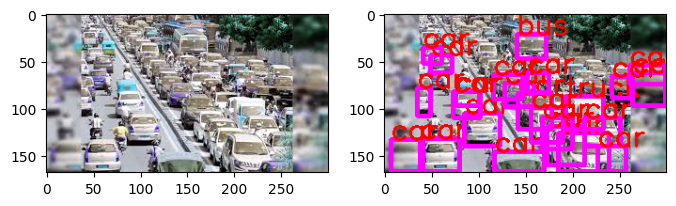

In [1]:
import cv2
import math
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as pt
with open("D:/repos/DeepLearningLab/yolo.yaml", "r") as file:
    config = yaml.safe_load(file)
img = cv2.imread(r"D:/dataset for lab programs/YOLO Dataset/images/train/traffic 6 data.jpg")
fig, ax = pt.subplots(nrows=1, ncols=2, figsize=(8,8))
ax[0].imshow(img)
model = YOLO("yolov8n.pt")
classNames = config['names']
results = model(img)
# Coordinates
for r in results:
    boxes = r.boxes
    for box in boxes:
        # Bounding box
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # Convert to int values
        # Put box in image
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
        # Confidence
        confidence = math.ceil((box.conf[0] * 100)) / 100
        print("Confidence --->", confidence)
        # Class name
        cls = int(box.cls[0])
        class_name = classNames[cls] if 0 <= cls < len(classNames) else "Unknown"
        print("Class name -->", class_name)
        # Object details
        org = [x1, y1]
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2
        cv2.putText(img, class_name, org, font, fontScale, color, thickness)
ax[1].imshow(img);